# Run a generic PyMT model

Import the `Sedflux3D` component from `pymt`. All of the components available to `pymt` are located in `pymt.components`. Here I've renamed the component to be `Model` to show that you could run these same commands with other models as well. For instance, you could instead import `Child` with `from pymt.components import Child as Model` and repeat this exercise with Child instead.

In [1]:
from __future__ import print_function

# Some magic to make plots appear within the notebook
%matplotlib inline

import numpy as np # In case we need to use numpy

In [2]:
from pymt import plugins

➡ plugins: Child, Avulsion, Plume, Sedflux3D, Subside


Instantiate the model. If you wanted, you could have multiple instances of the same model - each with their own state. A PyMT component is instantiate without any arguments.

In [3]:
model = plugins.Sedflux3D()

PyMT adds a docstring to the model. It is important to us that credit it given where credit is due. We want to make it clear that when we include a component in our framework the component is not ours but belong to the model's author. To that end, the model documentation includes a list of model authors, DOIs, as well as full citations to use if someone uses the model. In addition, to keep models from being black boxes, and because they are all open source, we provide links to source code. 

In [4]:
# help(model)

In [5]:
rm -rf _model # Clean up for the next step

The following code is generic for all `pymt` components - not just `Sedflux3D`. First we instantiate the component and then call its `setup` method to create a model simulation with the necessary input files (note that this is ***not*** a BMI method but something added by PyMT). `setup` takes an optional argument that gives a path to a folder that will contain the necessary input files (if not provided, a temporary folder will be used). `setup` returns the name of the config file and the path to the folder containing it (we'll use this information later when we run `initialize`).

In [6]:
config_file, initdir = model.setup('_model', run_duration=3650000.)

If we look inside the `_model` folder, we can see all of the necessary sedflux input files ready to run.

In [7]:
ls _model

sedflux_3d_argv.txt       sedflux_3d_process.kvf    sedflux_3d_sediment.kvf
sedflux_3d_bathy.csv      sedflux_3d_river.kvf
sedflux_3d_init.kvf       sedflux_3d_sea_level.csv


The `initialize` method reads all of the input files and gets the model ready to update through time.

In [8]:
model.initialize(config_file, dir=initdir)

In [9]:
model.set_value("channel_exit_water_flow__speed", 1.2)
model.set_value("channel_exit_x-section__mean_of_width", 400.)
model.set_value("channel_exit_x-section__mean_of_depth", 4.)
model.set_value("channel_exit_water_sediment~suspended__mass_concentration", .01)

array([ 0.01])

Here we update the model for 10 time steps, printing the model time after each step.

In [10]:
for t in range(10):
    model.update()
    print(model.get_current_time())

365.00000000036493
730.0000000010949
1095.00000000219
1460.00000000365
1825.000000005475
2190.000000007665
2555.00000001022
2920.00000001314
3285.0000000164246
3650.0000000200744


From the output it appears that sedflux is operating on a 1 year time step and is using units of *days*. We can double check that assumption.

In [11]:
model.time_units

'd'

Yep, *days*. And the time step...

In [12]:
model.get_time_step()

365.0

The `update_until` method gives us more control by allowing us to update to a particular time. Using the `units` keyword allows us to specify the "until" time. Here we update the model until 20 years.

In [13]:
model.update_until(200., units='year')
model.get_current_time()

73048.43975632306

In [14]:
model.time_units = 'year'
print(model.get_current_time())

200.00000000020003


We've covered how to setup and run a model, now we'll have a look at how to get data out of the model. This is done with the `get_value` method but first we need to look at what variables the model provides. This is held as a tuple of variable names and accessed through the `output_var_names` attribute.

In [15]:
model.output_var_names

('land-or-seabed_sediment_grain__mean_diameter',
 'sea_water__depth',
 'sea_bottom_sediment__bulk_mass-per-volume_density',
 'sea_bottom_surface__elevation',
 'sea_bottom_sediment_grain__mean_diameter',
 'bedrock_surface__elevation',
 'land-or-seabed_sediment__permeability',
 'sediment_grain__mean_diameter',
 'land-or-seabed_sediment_surface__y_derivative_of_elevation',
 'sea_bottom_sediment__porosity',
 'land-or-seabed_sediment_silt__volume_fraction',
 'land-or-seabed_sediment_surface__elevation',
 'land-or-seabed_sediment_clay__volume_fraction',
 'sea_bottom_sediment_mud__volume_fraction',
 'land-or-seabed_sediment_sand__volume_fraction',
 'land-or-seabed_sediment__mean_of_deposition_age',
 'sediment__mean_of_deposition_age',
 'sea_bottom_surface__y_derivative_of_elevation',
 'sea_bottom_sediment_clay__volume_fraction',
 'land-or-seabed_sediment__porosity',
 'land-or-seabed_sediment__bulk_mass-per-volume_density',
 'land-or-seabed_sediment_mud__volume_fraction',
 'land-or-seabed_sedi

In [16]:
model.input_var_names

('bedrock_surface__elevation',
 'channel_water_sediment~bedload__mass_flow_rate',
 'sea_bottom_sediment__increment_of_thickness',
 'bedrock_surface__increment_of_elevation',
 'channel_exit_water__volume_flow_rate',
 'channel_exit_water_flow__speed',
 'channel_exit_x-section__mean_of_width',
 'channel_exit_x-section__mean_of_depth',
 'channel_exit_water_sediment~suspended__mass_concentration')

So to get the values of, say, water depth,

In [17]:
model.get_value('sea_water__depth')

array([ 50.,  50.,  50., ..., -30., -30., -30.])

As with previous methods, you can use the `units` keyword to specify units. Here we get water depths in units of parsecs.

In [18]:
model.get_value('sea_water__depth', units='parsec')

array([  1.62038942e-15,   1.62038942e-15,   1.62038942e-15, ...,
        -9.72233655e-16,  -9.72233655e-16,  -9.72233655e-16])

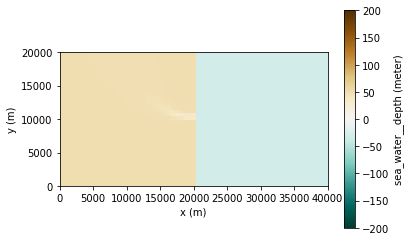

In [19]:
model.quick_plot('sea_water__depth', vmin=-200, vmax=200, cmap='BrBG_r')

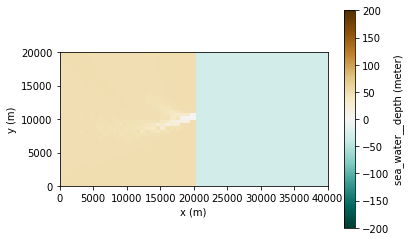

In [22]:
model.set_value("channel_exit_water_sediment~suspended__mass_concentration", .5)
for t in range(10):
    model.update()
model.quick_plot('sea_water__depth', vmin=-200, vmax=200, cmap='BrBG_r')